Branching GP Regression
--

*Alexis Boukouvalas, 2017*

Branching GP regression with Gaussian noise on the hematopoiesis data described in the paper "Gaussian processes for identifying branching dynamics in single cell data".

This notebook shows how to build a BGP model and plot the posterior model fit and posterior branching times.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Read the hematopoiesis data. This has been simplified to a small subset of 23 genes found to be branching.
We have also performed Monocle2 - DDRTree on this data. The results loaded include the Monocle estimated pseudotime, branching assignment (state) and the DDRTree latent dimensions.

In [2]:
Y = pd.read_csv('singlecelldata/hematoData.csv', index_col=[0])
monocle = pd.read_csv('singlecelldata/hematoMonocle.csv', index_col=[0])

In [3]:
Y.head()

,CAR2,APOE,MPO,PRTN3,CTSG,CEBPA,FOXP1,RUNX1,CEBPE,GFI1,...,MEF2C,MEIS1,GATA2,NFE2,TAL1,GATA1,KLF1,FLT3,SATB1,ELANE
W29956,0.0,14.272981,7.136490,2.378830,4.757660,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,2.378830,0.000000,3.568245,0.0,0.000000,0.0,0.000000
W30018,0.0,0.000000,14.331045,18.239511,14.331045,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,2.605644,0.000000,0.000000,0.0,1.302822,0.0,0.000000
W30161,0.0,8.191847,0.000000,4.095923,4.095923,0.0,4.095923,0.000000,0.0,0.000000,...,4.095923,0.0,4.095923,12.287769,4.095923,0.000000,0.0,0.000000,0.0,0.000000
W30258,0.0,8.889219,11.428996,11.428996,0.000000,0.0,0.000000,1.269889,0.0,0.000000,...,0.000000,0.0,1.269889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
W30296,0.0,0.000000,64.317993,27.564854,15.313807,0.0,0.000000,0.000000,0.0,1.020921,...,0.000000,0.0,0.000000,1.020921,0.000000,0.000000,0.0,0.000000,0.0,7.146443


In [4]:
monocle.head()

,State,StretchedPseudotime,DDRTreeDim1,DDRTreeDim2
0,3.0,0.312208,-0.728425,-4.253484
1,2.0,0.256831,-3.131191,-2.867801
2,3.0,0.435655,3.106984,-4.869838
3,3.0,0.413354,0.881536,-5.958776
4,2.0,0.274771,-3.366619,-2.444610


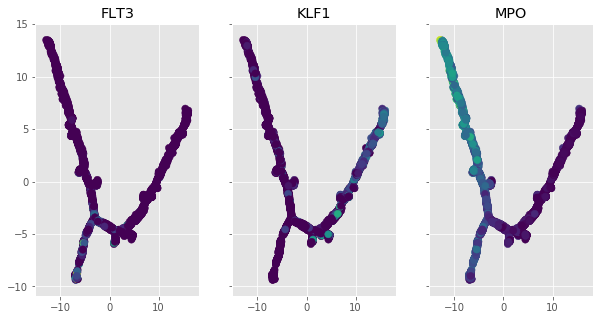

In [5]:
# Plot Monocle DDRTree space
genelist = ['FLT3','KLF1','MPO']
f, ax = plt.subplots(1, len(genelist), figsize=(10, 5), sharex=True, sharey=True)
for ig, g in enumerate(genelist):
        y = Y[g].values
        yt = np.log(1+y/y.max())
        yt = yt/yt.max()
        h = ax[ig].scatter(monocle['DDRTreeDim1'], monocle['DDRTreeDim2'],
                       c=yt, s=50, alpha=1.0, vmin=0, vmax=1)
        ax[ig].set_title(g)


In [6]:
import BranchedGP, time
def PlotGene(label, X, Y, s=3, alpha=1.0, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for li in np.unique(label):
        idxN = (label == li).flatten()
        ax.scatter(X[idxN], Y[idxN], s=s, alpha=alpha, label=int(np.round(li)))
    return fig, ax

### Fit BGP model
Notice the cell assignment uncertainty is higher for cells close to the branching point.


MPO BGP inference completed in 77.3 seconds.


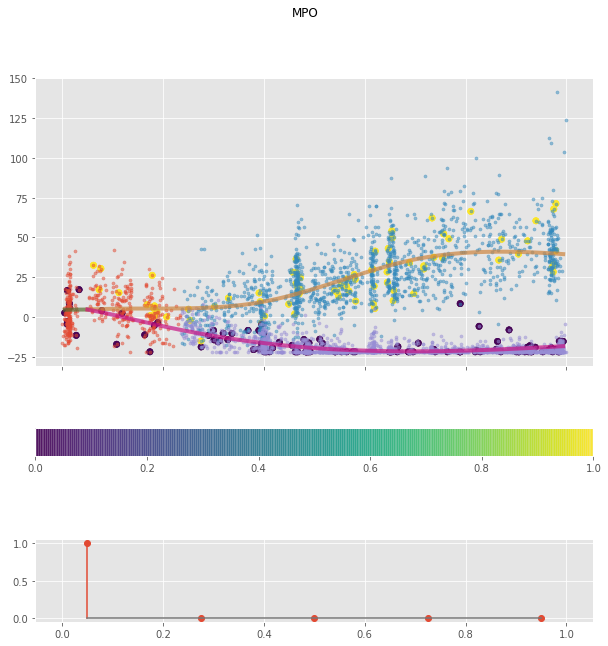

In [7]:
def FitGene(g, ns=20): # for quick results subsample data
    t = time.time()
    Bsearch = list(np.linspace(0.05, 0.95, 5)) + [1.1]  # set of candidate branching points
    GPy = (Y[g].iloc[::ns].values - Y[g].iloc[::ns].values.mean())[:, None]  # remove mean from gene expression data
    GPt = monocle['StretchedPseudotime'].values[::ns]
    globalBranching = monocle['State'].values[::ns].astype(int)
    d = BranchedGP.FitBranchingModel.FitModel(Bsearch, GPt, GPy, globalBranching)
    print(g, 'BGP inference completed in %.1f seconds.' %  (time.time()-t))
    # plot BGP
    fig,ax=BranchedGP.VBHelperFunctions.PlotBGPFit(GPy, GPt, Bsearch, d, figsize=(10,10))
    # overplot data
    f, a=PlotGene(monocle['State'].values, monocle['StretchedPseudotime'].values, Y[g].values-Y[g].iloc[::ns].values.mean(), 
                  ax=ax[0], s=10, alpha=0.5)
    fig.suptitle(g)    
    return d, fig, ax
d, fig, ax = FitGene('MPO')

CTSG BGP inference completed in 79.0 seconds.


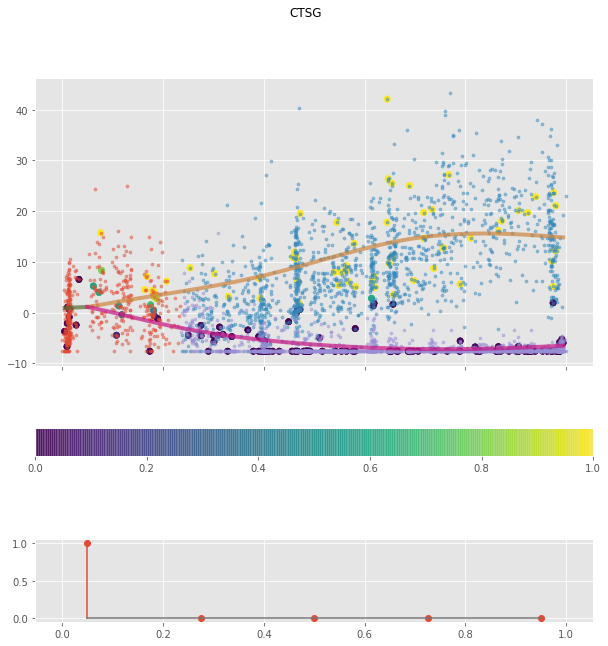

In [8]:
d_c, fig_c, ax_c = FitGene('CTSG')